In [1]:
%matplotlib inline

import configparser
import os

import requests
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse, stats, spatial
import scipy.sparse.linalg
from sklearn import preprocessing, decomposition
import librosa
import IPython.display as ipd
import json
#import tmdbsimple as tmdb
from itertools import chain
from pygsp import graphs, filters, plotting

plt.rcParams['figure.figsize'] = (17, 5)
plotting.BACKEND = 'matplotlib'

2018-01-23 14:03:37,039:[WARNING](pygsp.graphs.nngraphs.nngraph.<module>): Cannot import pyflann (used for faster kNN computations): Traceback (most recent call last):
  File "C:\Users\Valentin\Anaconda3\lib\site-packages\pygsp\graphs\nngraphs\nngraph.py", line 14, in <module>
    import pyflann as pfl
  File "C:\Users\Valentin\Anaconda3\lib\site-packages\pyflann\__init__.py", line 27, in <module>
    from pyflann.index import *
  File "C:\Users\Valentin\Anaconda3\lib\site-packages\pyflann\index.py", line 27, in <module>
    from pyflann.bindings.flann_ctypes import *
  File "C:\Users\Valentin\Anaconda3\lib\site-packages\pyflann\bindings\__init__.py", line 30, in <module>
    from pyflann.bindings.flann_ctypes import *
  File "C:\Users\Valentin\Anaconda3\lib\site-packages\pyflann\bindings\flann_ctypes.py", line 171, in <module>
    raise ImportError('Cannot load dynamic library. Did you compile FLANN?')
ImportError: Cannot load dynamic library. Did you compile FLANN?



In [2]:
dataset = pd.read_csv('Saved_Datasets/NewFeaturesDataset.csv')

In [3]:
dataset.head(3)

,id,budget,genres,imdb_id,overview,production_companies,release_date,revenue,title,director_name,...,actors_ids,actors_tenures,total_tenure,average_tenure,Total_profitability_actors,Metacritic,YouTube_Mean,Profitability,ROI,success
0,12,94000000,Animation|Family,266543,"Nemo, an adventurous young clownfish, is unexp...",Pixar Animation Studios,2003-05-30,940335536,Finding Nemo,Andrew Stanton,...,"[14, 5293, 12, 13, 18]","[18, 24, 2, 28, 14]",86,17.2,7310194071,90,0.218,846335536,2.639,1
1,16,12800000,Drama|Crime|Music,168629,"Selma, a Czech immigrant on the verge of blind...",Fine Line Features,2000-05-17,40031879,Dancer in the Dark,Lars von Trier,...,"[6748, 47, 52, 50, 53]","[49, 19, 21, 44, 15]",148,29.6,294261790,61,Error,27231879,2.127,1
2,22,140000000,Adventure|Fantasy|Action,325980,"Jack Sparrow, a freewheeling 17th-century pira...",Walt Disney Pictures,2003-09-07,655011224,Pirates of the Caribbean: The Curse of the Bla...,Gore Verbinski,...,"[1709, 116, 114, 118, 85]","[7, 9, 7, 22, 20]",65,13.0,15077223101,63,1.0,515011224,2.639,1


## 1. Data exploration ###

In [4]:
#number of movies per directors
all_comp = list(dataset['production_companies'])
diff_all_comp = list(set(all_comp))
print(len(diff_all_comp))
#print(diff_all_director)

freqComp = []
for i in diff_all_comp:
    freqComp.append(all_comp.count(i))
print(freqComp)    

#distribution nb movies per director
movies_per_comp = []
diff_freq_comp = list(set(freqComp))
print(diff_freq_comp)
for i in diff_freq_comp:
    movies_per_comp.append(freqComp.count(i))
print(movies_per_comp)    

701
[3, 3, 1, 2, 1, 3, 1, 1, 1, 1, 1, 2, 1, 6, 1, 146, 2, 1, 8, 3, 15, 1, 1, 1, 1, 102, 1, 1, 87, 1, 1, 4, 1, 1, 1, 1, 1, 8, 1, 1, 4, 2, 1, 2, 1, 1, 2, 1, 1, 7, 1, 1, 3, 12, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 2, 6, 1, 2, 1, 4, 1, 1, 9, 1, 1, 2, 8, 2, 1, 3, 1, 1, 29, 1, 1, 1, 2, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 2, 1, 3, 2, 3, 1, 1, 1, 1, 12, 1, 1, 1, 22, 9, 2, 1, 3, 1, 2, 7, 1, 1, 1, 8, 1, 1, 1, 1, 1, 41, 3, 1, 1, 2, 3, 1, 6, 1, 2, 1, 2, 3, 1, 1, 1, 1, 3, 1, 10, 1, 1, 1, 15, 1, 9, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 1, 1, 3, 1, 1, 1, 20, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 4, 4, 129, 1, 1, 1, 1, 10, 2, 1, 8, 3, 1, 1, 1, 1, 3, 1, 1, 1, 2, 9, 1, 1, 1, 1, 60, 2, 1, 1, 1, 25, 2, 2, 1, 1, 9, 1, 1, 1, 1, 55, 1, 5, 2, 1, 1, 2, 1, 1, 2, 1, 5, 1, 14, 2, 1, 1, 1, 1, 1, 7, 2, 5, 3, 1, 100, 2, 4, 1, 1, 1, 3, 1, 1, 2, 1, 1, 2, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 2, 18, 1, 13, 1, 1, 1, 1, 6, 1, 13, 1, 1, 1, 1, 1, 1, 3, 1, 1, 4, 1, 1, 16, 2, 1, 1, 1, 3, 44, 1

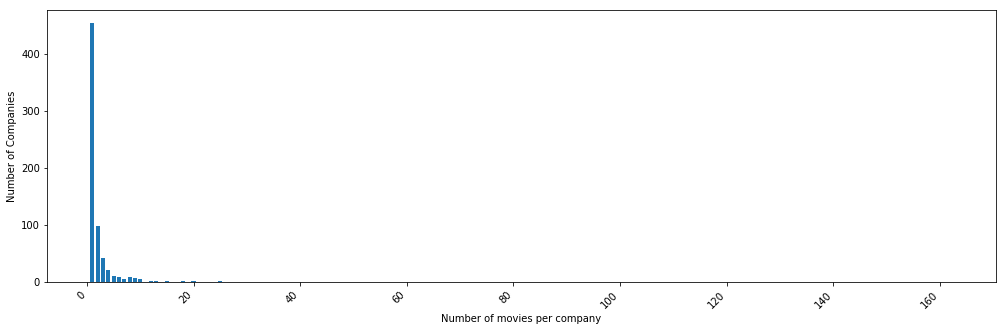

In [5]:
plt.bar(diff_freq_comp, movies_per_comp, align='center');
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right');
plt.xlabel('Number of movies per company');
plt.ylabel('Number of Companies');
plt.savefig('images/nb_movie_per_company.png', dpi=300, bbox_inches='tight')

## 2. Production companies similarty between pair of movies ###

In [6]:
companies_list = dataset['production_companies'].unique()
#print(companies_list)
nb_companies = len(companies_list)

companies_dic = {}
for i in range(0,len(dataset)):
    companies_dic[i]=dataset['production_companies'][i]
print(companies_dic)

{0: 'Pixar Animation Studios', 1: 'Fine Line Features', 2: 'Walt Disney Pictures', 3: 'Miramax Films', 4: 'Universal Pictures', 5: 'Revolution Films', 6: 'Gracie Films', 7: 'Anonymous Content', 8: 'Walt Disney Pictures', 9: 'New Line Cinema', 10: 'Imagine Entertainment', 11: 'Tree Line Films', 12: 'Lakeshore Entertainment', 13: 'BBC Films', 14: 'Paramount Pictures', 15: 'Summit Entertainment', 16: 'Castle Rock Entertainment', 17: 'Universal Pictures', 18: 'Plunge Pictures LLC', 19: 'DreamWorks SKG', 20: 'Columbia Pictures Corporation', 21: 'DreamWorks', 22: 'Village Roadshow Pictures', 23: 'WingNut Films', 24: 'WingNut Films', 25: 'WingNut Films', 26: 'Universal Pictures', 27: 'Pandora Cinema', 28: 'River Road Entertainment', 29: 'American Zoetrope', 30: 'DC Comics', 31: 'Village Roadshow Pictures', 32: 'Village Roadshow Pictures', 33: 'Intermedia Films', 34: 'DNA Films', 35: 'Lions Gate Films', 36: 'Universal Pictures', 37: 'DreamWorks SKG', 38: 'Warner Bros.', 39: 'The Weinstein Comp

In [7]:
companiesArray = np.ndarray(shape=(len(dataset), nb_companies), dtype=int)
for i in range(0, len(dataset)):
    #genreDict.setdefault(i, [])
    
    vector = np.zeros(nb_companies)
    
    #add vectors of 1's and 0's to obtain vector of genres
    vector += (companies_dic[i] == np.array(companies_list)).astype(int)
    
    #genreDict[i].append(vector)
    companiesArray[i] = vector

In [8]:
print(len(companiesArray[0]))
print(companiesArray.size)

701
1837321


In [9]:
Companies = pd.DataFrame(companiesArray, columns=companies_list)
Companies.head(10)

,Pixar Animation Studios,Fine Line Features,Walt Disney Pictures,Miramax Films,Universal Pictures,Revolution Films,Gracie Films,Anonymous Content,New Line Cinema,Imagine Entertainment,...,Open Road Films (II),Industrial House Films,Cosmo-Films,Amazon Studios,STX Entertainment,Twentieth Century-Fox,Herrick Entertainment,Visible Pictures,ARY Films,Believe the Film / Power of 3
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
W = np.dot(companiesArray,np.transpose(companiesArray))

In [11]:
np.fill_diagonal(W, 0)

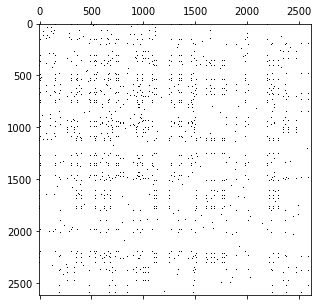

In [12]:
plt.spy(W)

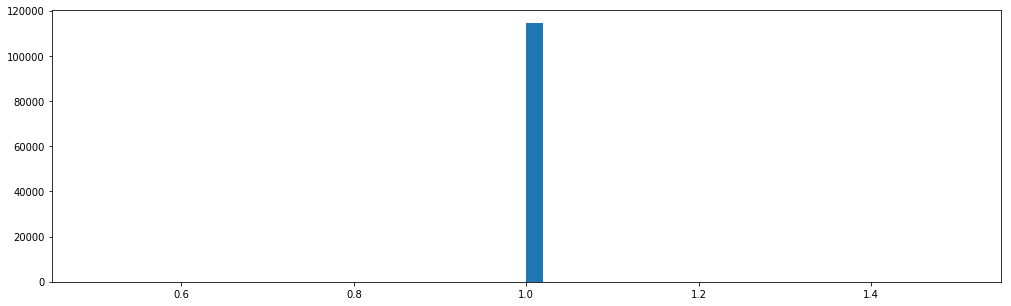

In [13]:
plt.hist(W[W > 0].reshape(-1), bins=50);

In [14]:
print('There are {} edges equal to zero '.format(np.sum(W == 0)/2))
print('There are {} edges equal to one '.format(np.sum(W == 1)/2))

There are 3377529.5 edges equal to zero 
There are 57291.0 edges equal to one 


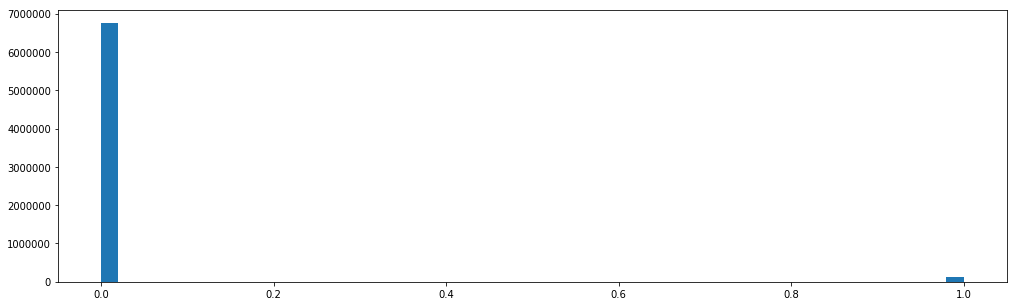

In [15]:
plt.hist(W.reshape(-1), bins=50);

In [16]:
W = pd.DataFrame(W)
W.head()

,0,1,2,3,4,5,6,7,8,9,...,2611,2612,2613,2614,2615,2616,2617,2618,2619,2620
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
W.to_csv('Saved_Datasets/NormalizedCompaniesW.csv', index=False)

### 3. Similarity between number of movies per companies between pair of movies ###

In [18]:
#Apply nb movie per company to the dataset
mov_per_company_data = []
for i in range(0,len(dataset['production_companies'])):
    for j in range(0,len(diff_all_comp)):
        if dataset['production_companies'][i] == diff_all_comp[j]:
            mov_per_company_data.append(freqComp[j])

In [19]:
#print(mov_per_company_data)

In [20]:
#W = np.ndarray(shape=(10, 10), dtype=int)
W_diff = np.zeros(shape=(len(dataset), len(dataset)), dtype=int)
for i in range(0,len(dataset)):
    for j in range(i,len(dataset)):
        W_diff[i][j] = abs(mov_per_company_data[i]-mov_per_company_data[j])

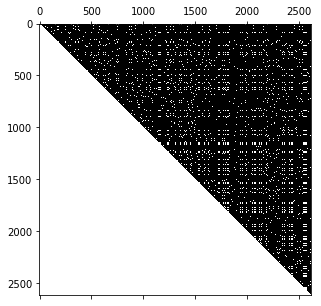

In [21]:
plt.spy(W_diff)

In [22]:
bigger = W_diff.transpose() > W_diff
W_diff = W_diff - W_diff*bigger + W_diff.transpose()*bigger
np.fill_diagonal(W_diff, 0)

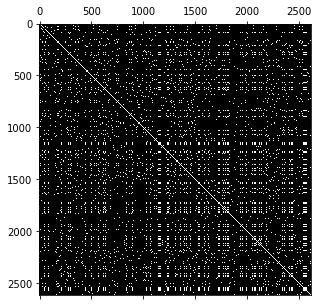

In [23]:
plt.spy(W_diff)

In [24]:
print(W_diff)

[[ 0  2 85 ...,  1  4  1]
 [ 2  0 83 ...,  3  2  3]
 [85 83  0 ..., 86 81 86]
 ..., 
 [ 1  3 86 ...,  0  5  0]
 [ 4  2 81 ...,  5  0  5]
 [ 1  3 86 ...,  0  5  0]]


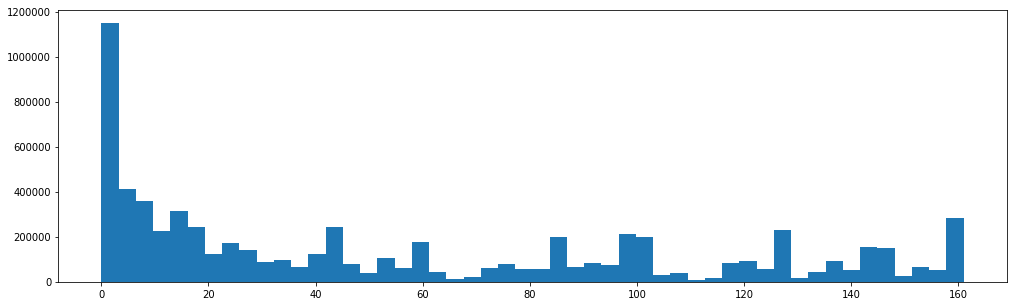

In [25]:
plt.hist(W_diff.reshape(-1),bins=50);

#### Weights normalization ####

In [26]:
val_75 = np.percentile(W_diff,75)
print(val_75)

99.0


In [27]:
W_diff_norm = np.zeros(shape=(len(dataset), len(dataset)), dtype=float)
for i in range(0,len(dataset)):
    for j in range(i,len(dataset)):
        if W_diff[i][j] == 0:
            W_diff_norm[i][j] = 1
        elif W_diff[i][j] <= val_75:  
            W_diff_norm[i][j] = 1-(W_diff[i][j])/(val_75)
        else:
            W_diff_norm[i][j] = 0

In [28]:
bigger = W_diff_norm.transpose() > W_diff_norm
W_diff_norm = W_diff_norm - W_diff_norm*bigger + W_diff_norm.transpose()*bigger
np.fill_diagonal(W_diff_norm, 0)

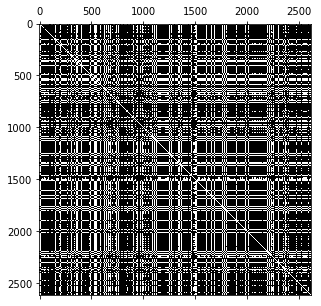

In [29]:
plt.spy(W_diff_norm)

In [30]:
DiffNormW = pd.DataFrame(W_diff_norm)
DiffNormW.head()

,0,1,2,3,4,5,6,7,8,9,...,2611,2612,2613,2614,2615,2616,2617,2618,2619,2620
0,0.000000,0.979798,0.141414,0.606061,0.000000,0.989899,0.989899,0.989899,0.141414,0.000000,...,0.000000,0.989899,0.979798,0.000000,0.777778,1.000000,0.989899,0.989899,0.959596,0.989899
1,0.979798,0.000000,0.161616,0.626263,0.000000,0.989899,0.989899,0.989899,0.161616,0.010101,...,0.000000,0.969697,1.000000,0.000000,0.797980,0.979798,0.969697,0.969697,0.979798,0.969697
2,0.141414,0.161616,0.000000,0.535354,0.242424,0.151515,0.151515,0.151515,1.000000,0.848485,...,0.404040,0.131313,0.161616,0.404040,0.363636,0.141414,0.131313,0.131313,0.181818,0.131313
3,0.606061,0.626263,0.535354,0.000000,0.000000,0.616162,0.616162,0.616162,0.535354,0.383838,...,0.000000,0.595960,0.626263,0.000000,0.828283,0.606061,0.595960,0.595960,0.646465,0.595960
4,0.000000,0.000000,0.242424,0.000000,0.000000,0.000000,0.000000,0.000000,0.242424,0.393939,...,0.838384,0.000000,0.000000,0.838384,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [31]:
DiffNormW.to_csv('Saved_Datasets/DiffNormCompW.csv', index=False)

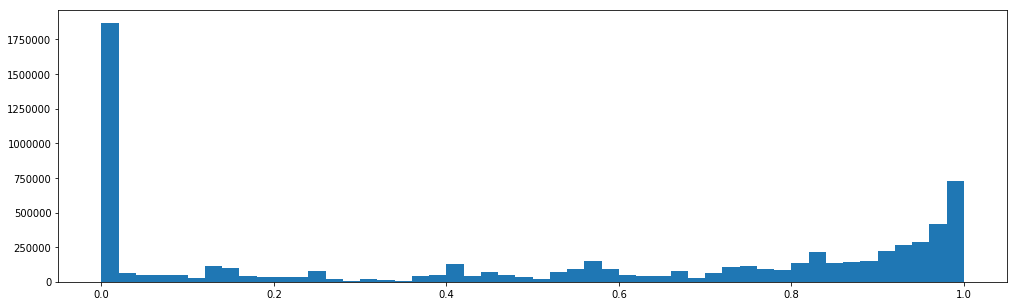

In [32]:
plt.hist(W_diff_norm.reshape(-1),bins=50);

In [33]:
G = graphs.Graph(W_diff_norm)
G.compute_laplacian('normalized')

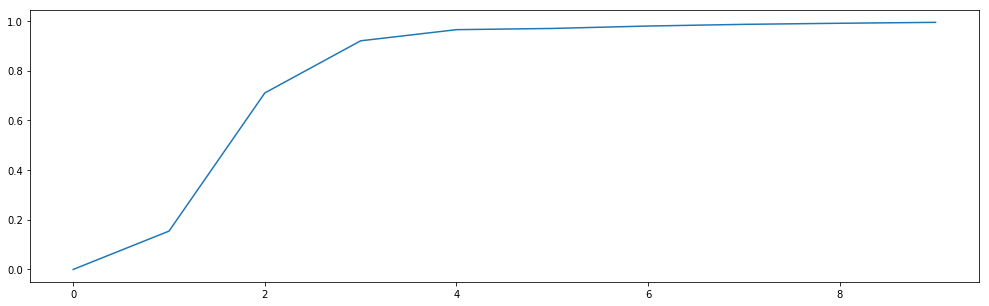

In [34]:
G.compute_fourier_basis(recompute=True)
plt.plot(G.e[0:10]);

In [35]:
labels = preprocessing.LabelEncoder().fit_transform(dataset['success'])
G.set_coordinates(G.U[:,1:3])

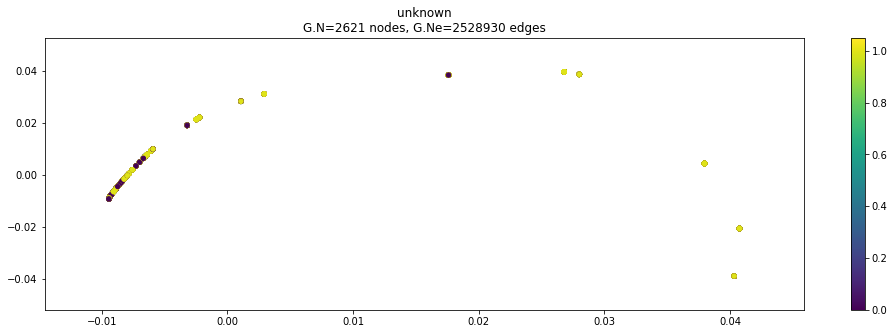

In [36]:
G.plot_signal(labels, vertex_size=20)

In [37]:
NEIGHBORS = 400

#sort the order of the weights
sort_order = np.argsort(W_diff_norm, axis = 1)

#declaration of a sorted weight matrix
sorted_weights = np.zeros((len(W_diff_norm), len(W_diff_norm)))

for i in range (0, len(W_diff_norm)):  
    for j in range(0, len(W_diff_norm)):
        if (j >= len(W_diff_norm) - NEIGHBORS):
            #copy the k strongest edges for each node
            sorted_weights[i, sort_order[i,j]] = W_diff_norm[i,sort_order[i,j]]
        else:
            #set the other edges to zero
            sorted_weights[i, sort_order[i,j]] = 0

#ensure the matrix is symmetric
bigger = sorted_weights.transpose() > sorted_weights
sorted_weights = sorted_weights - sorted_weights*bigger + sorted_weights.transpose()*bigger

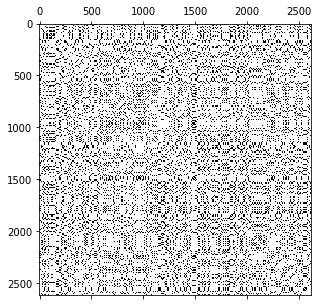

In [38]:
plt.spy(sorted_weights)

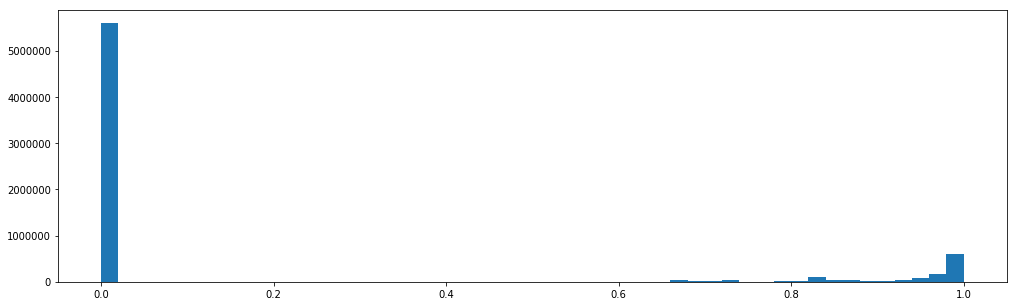

In [39]:
plt.hist(sorted_weights.reshape(-1),bins=50);

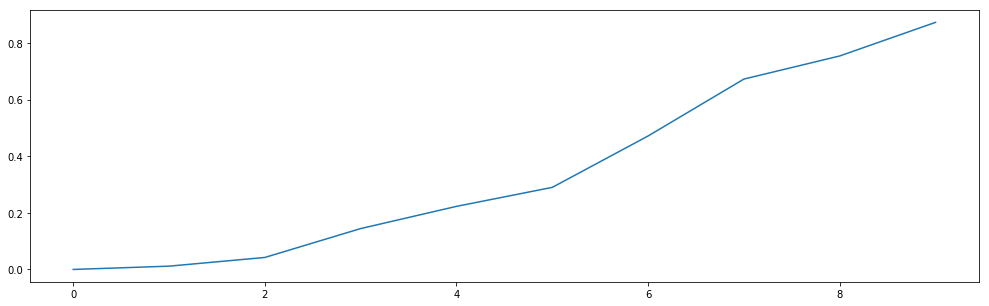

In [40]:
G = graphs.Graph(sorted_weights)
G.compute_laplacian('normalized')
G.compute_fourier_basis(recompute=True)
plt.plot(G.e[0:10]);

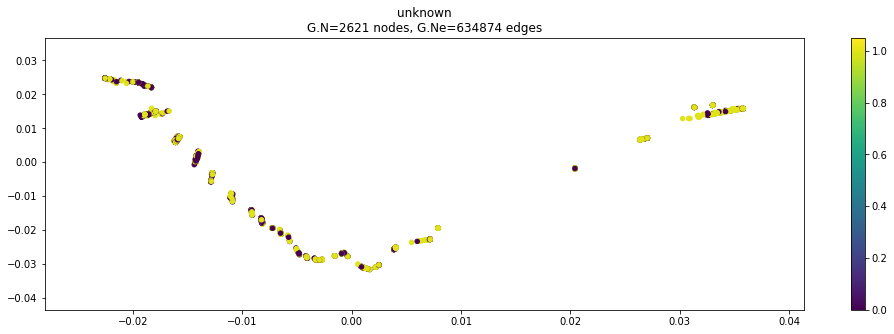

In [41]:
labels = preprocessing.LabelEncoder().fit_transform(dataset['success'])
G.set_coordinates(G.U[:,1:3])
G.plot_signal(labels, vertex_size=20)